In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv('processed_stroke_data_train.csv')

# Separate features and target
X = train_data.drop(columns=['stroke'])
y = train_data['stroke']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<font color="bluegrey" size=+1.0><b>Adaptive Gradient Boosting (XGBoost + LightGBM)</b></font>

In [3]:
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
lgbm_model = LGBMClassifier(random_state=42)

xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict_proba(X_test)[:, 1]  # Probability for the positive class
lgbm_pred = lgbm_model.predict_proba(X_test)[:, 1]

ensemble_pred = (xgb_pred + lgbm_pred) / 2

# Convert probabilities to binary predictions (threshold = 0.5)
ensemble_binary_pred = (ensemble_pred >= 0.5).astype(int)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, ensemble_binary_pred)
roc_auc = roc_auc_score(y_test, ensemble_pred)
report = classification_report(y_test, ensemble_binary_pred)

# Print metrics
print(f"Ensemble Model Accuracy: {accuracy:.2f}")
print(f"Ensemble Model ROC-AUC: {roc_auc:.2f}")
print("\nClassification Report:\n", report)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 149, number of negative: 3121
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 3270, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.045566 -> initscore=-3.041962
[LightGBM] [Info] Start training from score -3.041962
Ensemble Model Accuracy: 0.95
Ensemble Model ROC-AUC: 0.79

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       780
           1       0.00      0.00      0.00        38

    accuracy                           0.95       818
   macro avg       0.48      0.50      0.49       818
weighted avg       0.91      0.95      0.93       818



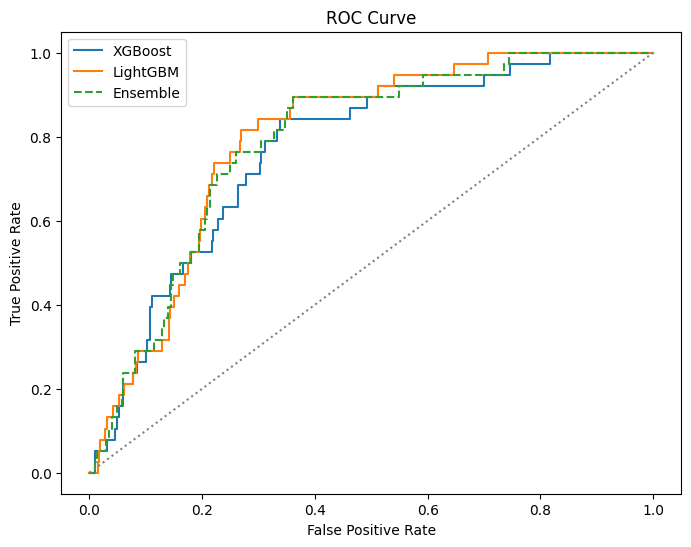

In [4]:
from sklearn.metrics import roc_curve

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_pred)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, lgbm_pred)
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, ensemble_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label="XGBoost")
plt.plot(fpr_lgbm, tpr_lgbm, label="LightGBM")
plt.plot(fpr_ensemble, tpr_ensemble, label="Ensemble", linestyle="--")
plt.plot([0, 1], [0, 1], color='gray', linestyle=":")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

C:\Users\zen\AppData\Local\Temp\ipykernel_32340\3888146758.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Combined Importance', y='Feature', data=importance_df.head(10), palette='viridis')


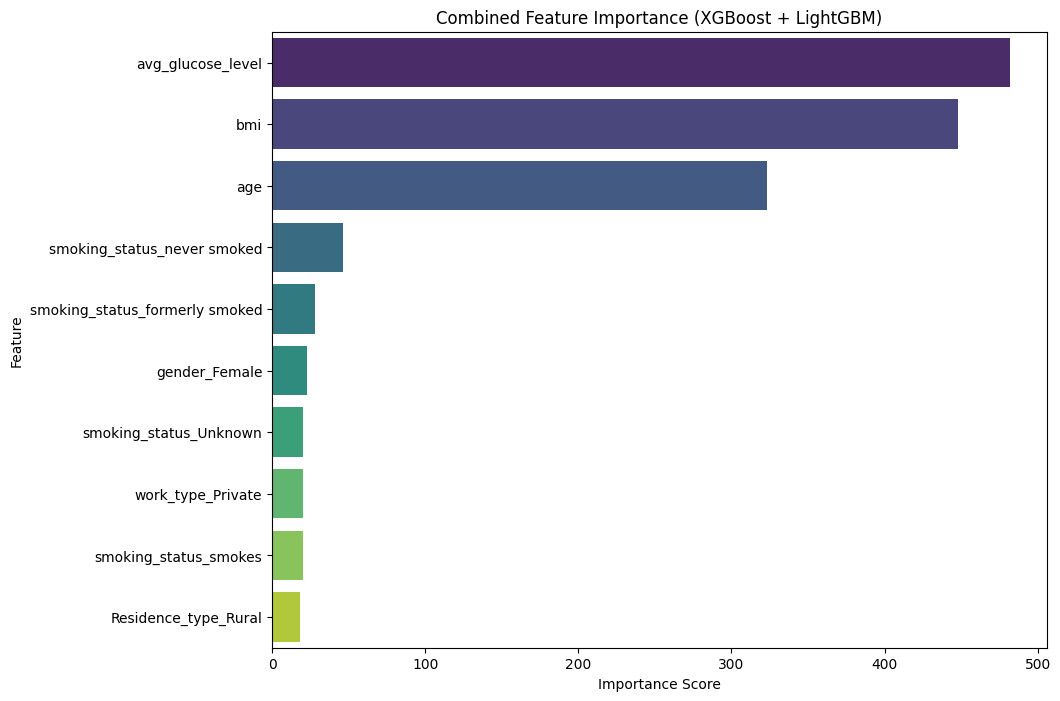

In [7]:
xgb_importance = xgb_model.feature_importances_  # From XGBoost
lgbm_importance = lgbm_model.feature_importances_  # From LightGBM

# Combine the importances (simple average)
combined_importance = (xgb_importance + lgbm_importance) / 2

# Create a DataFrame for visualization
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Combined Importance': combined_importance
})

# Sort by importance
importance_df = importance_df.sort_values(by='Combined Importance', ascending=False)

# Plot the combined feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Combined Importance', y='Feature', data=importance_df.head(10), palette='viridis')
plt.title("Combined Feature Importance (XGBoost + LightGBM)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

<font color="bluegrey" size=+1.0><b>Save results</b></font>

In [8]:
results = {
    "Model": ["XGBoost + LightGBM Ensemble"],
    "Accuracy": [accuracy_score(y_test, ensemble_binary_pred)],
    "ROC AUC": [roc_auc_score(y_test, ensemble_pred)]
}

results_df = pd.DataFrame(results)
print(results_df)

                         Model  Accuracy   ROC AUC
0  XGBoost + LightGBM Ensemble  0.948655  0.787281


<font color="bluegrey" size=+1.0><b>Save models</b></font>

In [11]:
from joblib import dump

dump(xgb_model, 'XGBoost_model.pkl')
dump(lgbm_model, 'lightgbm_model.pkl')

# ensemble logic as a custom function
def ensemble_predict(X):
    """
    Function to predict using the XGBoost and LightGBM ensemble.
    Averages the probabilities from both models.
    """
    xgb_pred = xgb_model.predict_proba(X)[:, 1]
    lgbm_pred = lgbm_model.predict_proba(X)[:, 1]
    ensemble_pred = (xgb_pred + lgbm_pred) / 2
    return ensemble_pred

dump(ensemble_predict, 'ensemble_model.pkl')
print("Successfully saved the model.")


Successfully saved the model.
